In [1]:
import sys
sys.path.append('..')
import numpy as np
import tqdm
import argparse
import pyDOE
from sklearn.gaussian_process.kernels import Matern

from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d
import robustGP.tools as tools
import robustGP.acquisition.acquisition as ac

In [2]:
def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    bounds = np.asarray([(0, 1)] * NDIM)
    if initial_design is None:
        initial_design = 5 * NDIM
    if isinstance(initial_design, int):
        initial_design = pyDOE.lhs(
            n=NDIM, samples=initial_design, criterion="maximin", iterations=50
        )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin


bounds = np.asarray([[0, 1], [0, 1]])
# For plots
x, y = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))
xs, ys = np.linspace(0, 1, 20), np.linspace(0, 1, 20)
(XYs, (xmgs, ymgs)) = tools.pairify((xs, ys))

xsmall, ysmall = np.linspace(0, 1, 4), np.linspace(0, 1, 4)
(XYsmall, (xmgsmall, ymgsmall)) = tools.pairify((xsmall, ysmall))

initial_design = np.genfromtxt("tmp/initial_design.txt")
branin = initialize_branin(initial_design)



In [3]:
integration_points = pyDOE.lhs(2, 100, criterion="maximin", iterations=50)
imse = branin.gp.predict(integration_points, return_std=True)[1]**2

In [4]:
# function_aIMSE(XY)
np.genfromtxt("tmp/aIMSE_Z.txt", skip_header=True, delimiter=',')

array([[0.        , 0.        , 0.02928935],
       [0.        , 0.02040816, 0.02923514],
       [0.        , 0.04081633, 0.02918386],
       ...,
       [1.        , 0.95918367, 0.02815524],
       [1.        , 0.97959184, 0.02837105],
       [1.        , 1.        , 0.02858986]])

<Figure size 600x600 with 0 Axes>

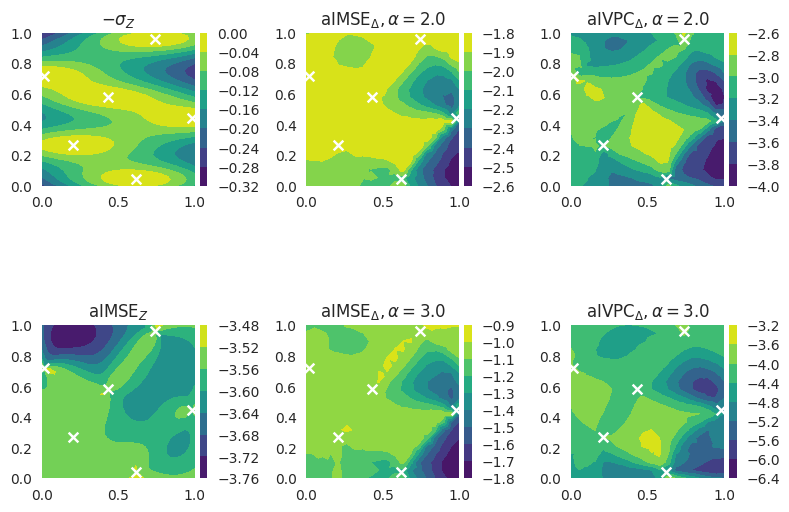

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('seaborn-v0_8')
plt.rc("text.latex", preamble=r"\usepackage{amsmath} \usepackage{amssymb}")
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["DejaVu", "Verdana", "Computer Modern Roman"],
    # 'font.sans-serif' : ['Tahoma', 'DejaVu Sans','Lucida Grande', 'Verdana'],
    'image.cmap': u'viridis',
    'figure.figsize': [6, 6],
    'savefig.dpi': 200
})

plt.set_cmap('viridis')
data = np.genfromtxt("tmp/aIMSE_Z.txt", skip_header=True, delimiter=',')
# plt.plot(data[:, -1])
fig, axs = plt.subplots(2, 3, figsize=(8, 6))

im = axs[0, 0].contourf(xmg, ymg, -branin.gp.predict(XY, return_std=True)[1].reshape(50, 50)**2)
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0, 0].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_title(r'$-\sigma_Z$')


im = axs[1, 0].tricontourf(data[:, 0], data[:, 1], np.log(data[:, 2]))
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 0].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_title(r'$\mathrm{aIMSE}_Z$')


data_aIMSE = np.genfromtxt("tmp/aIMSE_Delta_2.txt", skip_header=True, delimiter=',')
im = axs[0, 1].tricontourf(data_aIMSE[:, 0], data_aIMSE[:, 1], np.log(data_aIMSE[:, 2]))
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0, 1].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_title(r'$\mathrm{aIMSE}_\Delta, \alpha=2.0$')

# plt.scatter(data[:, 0], data[:, 1])
data_aIMSE = np.genfromtxt("tmp/aIMSE_Delta_3.txt", skip_header=True, delimiter=',')
im = axs[1, 1].tricontourf(data_aIMSE[:, 0], data_aIMSE[:, 1], np.log(data_aIMSE[:, 2]))
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 1].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_title(r'$\mathrm{aIMSE}_\Delta, \alpha=3.0$')

data_aIVPC = np.genfromtxt("tmp/aIVPC_Delta_2.txt", skip_header=True, delimiter=',')
im = axs[0, 2].tricontourf(data_aIVPC[:, 0], data_aIVPC[:, 1], np.log(data_aIVPC[:, 2]))
divider = make_axes_locatable(axs[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0, 2].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[0, 2].set_aspect('equal')
axs[0, 2].set_title(r'$\mathrm{aIVPC}_\Delta, \alpha=2.0$')

# plt.scatter(data[:, 0], data[:, 1])
data_aIVPC = np.genfromtxt("tmp/aIVPC_Delta_3.txt", skip_header=True, delimiter=',')
im = axs[1, 2].tricontourf(data_aIVPC[:, 0], data_aIVPC[:, 1], np.log(data_aIVPC[:, 2]))
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 2].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[1, 2].set_aspect('equal')
axs[1, 2].set_title(r'$\mathrm{aIVPC}_\Delta, \alpha=3.0$')

plt.tight_layout()

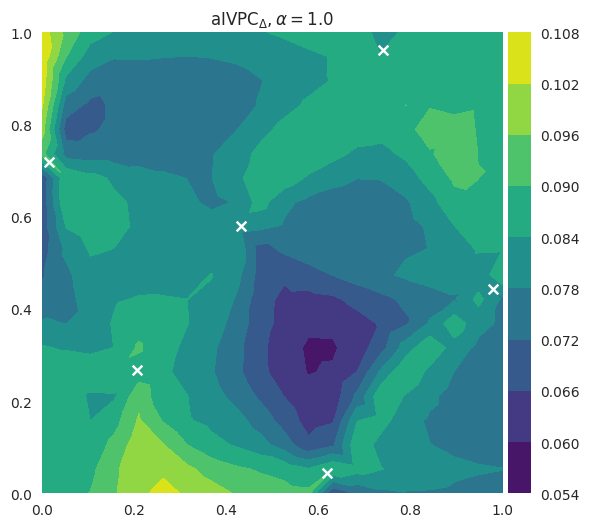

In [6]:
fig, axs = plt.subplots(1,1)
data_aIMSE = np.genfromtxt("tmp/aIVPC_Delta_1.txt", skip_header=True, delimiter=',')
im = axs.tricontourf(data_aIMSE[:, 0], data_aIMSE[:, 1], data_aIMSE[:, 2])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs.set_aspect('equal')
axs.set_title(r'$\mathrm{aIVPC}_\Delta, \alpha=1.0$')
plt.tight_layout()

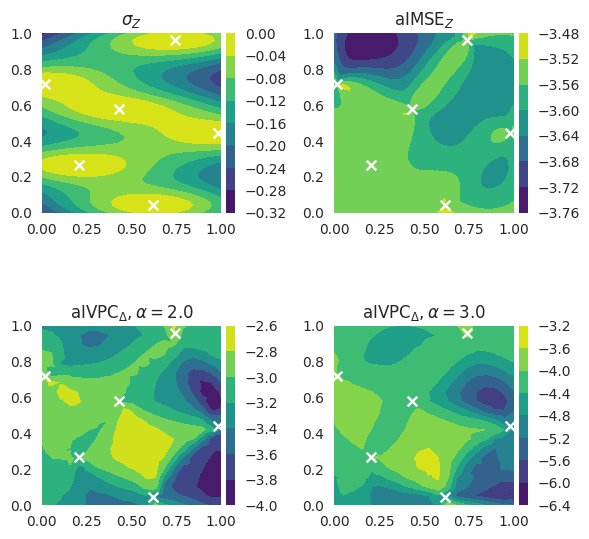

In [13]:
fig, axs = plt.subplots(2, 2)


im = axs[0, 0].contourf(xmg, ymg, -branin.gp.predict(XY, return_std=True)[1].reshape(50, 50)**2)
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0, 0].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_title(r'$\sigma_Z$')


im = axs[0, 1].tricontourf(data[:, 0], data[:, 1], np.log(data[:, 2]))
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0, 1].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_title(r'$\mathrm{aIMSE}_Z$')


data_aIMSE = np.genfromtxt("tmp/aIVPC_Delta_2.txt", skip_header=True, delimiter=',')
im = axs[1, 0].tricontourf(data_aIMSE[:, 0], data_aIMSE[:, 1], np.log(data_aIMSE[:, 2]))
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 0].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_title(r'$\mathrm{aIVPC}_\Delta, \alpha=2.0$')

# plt.scatter(data[:, 0], data[:, 1])
data_aIMSE = np.genfromtxt("tmp/aIVPC_Delta_3.txt", skip_header=True, delimiter=',')
im = axs[1, 1].tricontourf(data_aIMSE[:, 0], data_aIMSE[:, 1], np.log(data_aIMSE[:, 2]))
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 1].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', color='w', alpha=1.0)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_title(r'$\mathrm{aIVPC}_\Delta, \alpha=3.0$')


plt.tight_layout()

In [8]:

import multiprocessing
def save_at_each_iteration_parallel(filename, header=None, nworkers=4):
    def decorator(function):
        pool = multiprocessing.Pool(processes=nworkers)
        def pooled_func(XY, *args, **kwargs):
            elt_func = lambda xy: function(xy.reshape(-1, 2), *args, **kwargs)
            result = pool.map(elt_func, XY)
            return result
        return pooled_func

    return decorator

In [9]:
import functools, time

def pooled_func(XY, *args, **kwargs):
    elt_func = lambda xy: function(xy.reshape(-1, 2), *args, **kwargs)
    result = multiprocessing.pool.map(elt_func, XY)
    return result


def parallel(func=None, **options):
    if func is None:
        return functools.partial(parallel, **options)

    def wrapper(iterable, **kwargs):
        processes = options["processes"]

        with multiprocessing.Pool(processes) as pool:
            result = pool.map(func, iterable)

        return result

    return wrapper


def test(i):
    time.sleep(1)
    print(f"{i}: {i * i}")

test_parallel = parallel(test, processes=6)



In [10]:
def function_pool(XY):
    return augmented_IMSE_Delta(
        branin,
        XY,
        scenarios=None,
        integration_points=integration_points,
        alpha=1.0,
    )

In [11]:
func_par = parallel(pooled_func, processes=4)

In [12]:
func_par(XYs)

AttributeError: module 'multiprocessing.pool' has no attribute 'map'